In [16]:
import folium
import pandas as pd
from shapely.geometry import Polygon
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
import math
import shapely.geometry as geometry
from shapely.ops import cascaded_union, polygonize

%config InlineBackend.figure_format = 'retina'

# Loading the data

### DataFrame of activities

Data Schema: 

<li>Vessel_id: the unique identifier of the vessel doing the activity
<li>StartTime: timestamp of when the vessel entered the port (UTC)
<li>Duration: Duration of the activity (in hours)
<li>Location: latitude, longitude (in decimal number)
<li>class_calc: Class of the Vessel (Cargo, Tanker)
<li>Flag : “Nationality” of the vessel
<li>Name: Name of the vessel
<li>Size: Size of the vessel
<li>Subclass Documented : Subclass of the Vessel (Tanker > LNG Tanker, LPG Tanker, Crude Oil Tanker….)


In [17]:
drifting_df = pd.read_csv('drifting_events_itc.csv')

# mooring_df = pd.read_csv('mooring_events_itc.csv')

In [18]:
drifting_df

,vessel_id,type,start_ts,end_ts,lon,lat,country,duration_hours,class_calc,flag,name,size,subclass_documented
0,5905c34de96ea258a40e2f48,LOW_SPEED_DRIFTING,2018-04-28 14:36:13,2018-05-01 04:56:02,21.00525,36.57825,Greece,62.330278,Tanker,Greece,MARATHA,244.0,Crude Oil Tanker
1,5905c34de96ea258a40e2f48,LOW_SPEED_DRIFTING,2018-05-08 00:32:19,2018-05-08 09:00:00,25.72370,39.95839,Greece,8.461389,Tanker,Greece,MARATHA,244.0,Crude Oil Tanker
2,5905c348e1db924c23572efc,LOW_SPEED_DRIFTING,2018-04-30 14:52:06,2018-05-01 05:53:10,24.82184,38.39685,Greece,15.017778,Tanker,Malta,FANEROMENI A,180.0,Oil Products Tanker
3,5905c348e1db924c23572efc,LOW_SPEED_DRIFTING,2018-05-01 06:30:02,2018-05-01 13:58:06,24.86876,38.24645,Greece,7.467778,Tanker,Malta,FANEROMENI A,180.0,Oil Products Tanker
4,5905c348e1db924c23572efc,LOW_SPEED_DRIFTING,2018-05-01 14:43:47,2018-05-01 20:28:56,24.87212,38.25446,Greece,5.752500,Tanker,Malta,FANEROMENI A,180.0,Oil Products Tanker
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4281,5905c40e81e6d85847cecc56,LOW_SPEED_DRIFTING,2018-09-30 01:06:40,2018-09-30 04:08:14,23.05243,36.32137,Greece,3.026111,Cargo,Panama,ALGRACE,149.0,General Cargo
4282,5905c4c20328b758c69a628b,LOW_SPEED_DRIFTING,2018-09-29 10:25:04,2018-09-29 19:22:18,22.16272,36.75503,Greece,8.953889,Tanker,MarshallIslands,FAIRCHEM KISO,146.0,Oil/Chemicals Tanker
4283,5905c347398ddf4c832254c4,LOW_SPEED_DRIFTING,2018-09-29 19:17:24,2018-09-30 02:56:38,29.87890,35.32945,Greece,7.653889,Cargo,Lebanon,ELEVATION,188.0,Livestock Carrier
4284,5905c349fdae05589ad8f6f1,LOW_SPEED_DRIFTING,2018-09-29 22:39:13,2018-09-30 09:38:29,23.51476,37.78352,Greece,10.987778,Cargo,Togo,RAINBOW-H,91.0,General Cargo


### Polygons

In [19]:
with open('greek_polygons.pkl', 'rb') as f:
    greek_eez, greek_ports = pickle.load(f)

In [20]:
GREECE_EEZ_SHAPELY = Polygon(greek_eez)
GREECE_PORTS_SHAPELY = []
for poly in greek_ports:
    try:
        poly_shapely = Polygon(poly)
    except ValueError:
        poly_shapely = Polygon(poly[0])
    GREECE_PORTS_SHAPELY.append(poly_shapely)

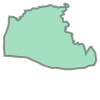

In [21]:
GREECE_EEZ_SHAPELY

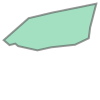

In [22]:
GREECE_PORTS_SHAPELY[5]

In [29]:
drifting_df[['lon','lat']].to_json()

'{"lon":{"0":21.00525,"1":25.7237,"2":24.82184,"3":24.86876,"4":24.87212,"5":24.83631,"6":24.83323,"7":25.26859,"8":25.79377,"9":23.48767,"10":23.88836,"11":27.84564,"12":25.64197,"13":25.3641,"14":25.38973,"15":26.58543,"16":26.57965,"17":27.98212,"18":25.75762,"19":25.00737,"20":24.75592,"21":25.08676,"22":25.1206,"23":25.0225,"24":24.99112,"25":25.84419,"26":26.5374,"27":26.53977,"28":26.51851,"29":22.21594,"30":25.64054,"31":25.50601,"32":25.55648,"33":25.64498,"34":25.50187,"35":25.68999,"36":25.15841,"37":25.03896,"38":24.61337,"39":24.77898,"40":24.91272,"41":25.23042,"42":24.59537,"43":24.94266,"44":25.04114,"45":24.94961,"46":24.55549,"47":25.01106,"48":25.11161,"49":24.87754,"50":24.9154,"51":24.89517,"52":24.83744,"53":24.62056,"54":24.67263,"55":25.06215,"56":25.04953,"57":24.73792,"58":24.8185,"59":24.65821,"60":26.5693,"61":26.63171,"62":23.56337,"63":23.92203,"64":24.28613,"65":23.95475,"66":23.61364,"67":18.89833,"68":18.89333,"69":18.88214,"70":18.90398,"71":18.97202,"

In [ ]:
# Code example: How to create a map in Folium?

In [23]:
TLV_CENTER = [32.075382, 34.770270]

dict_places = [{'name': 'Teder', 'type': 'Bar', 
                'coordinates': [32.060296, 34.769324]},
               {'name': 'Sputnik', 'type': 'Bar', 
                'coordinates': [32.062826, 34.773077]},
               {'name': 'Rubi', 'type': 'Bar', 
                'coordinates': [32.095255, 34.774840]},
               {'name': 'TYO', 'type': 'Restaurant', 
                'coordinates': [32.064810, 34.769906]},
               {'name': 'Malka', 'type': 'Restaurant', 
                'coordinates': [32.078254, 34.789372]}]


with open('tlv_polygon.pkl', 'rb') as f:
    tlv_polygon = pickle.load(f)
TLV_SHAPELY = Polygon(tlv_polygon)

In [24]:
TILES = 'OpenStreetMap'

my_tlv = folium.Map(location=TLV_CENTER, zoom_start=13, tiles=TILES)


folium.GeoJson(TLV_SHAPELY, 
               style_function = lambda feature: {'color': 'green', 
                                                 'fillOpacity':0.2, 
                                                 'weight':3}).add_to(my_tlv)

for place in dict_places:
    if place['type'] == 'Bar':
        color='blue'
    else:
        color='red'
    folium.Marker(place['coordinates'], 
                  icon=folium.Icon(color=color), 
                  radius=3, 
                  opacity=1).add_to(my_tlv)

In [25]:
my_tlv